# Radar Data Preprocessing Pipeline

This notebook prepares radar and IMU data for timestamp calibration and sensor fusion:

1. **Load ROS bag data** (radar, IMU, state)
2. **Fix CPU counter resets** (32-bit overflow correction)
3. **Estimate radar velocity** (Weighted Least Squares)
4. **Integrate IMU acceleration** (with drift correction)
5. **Filter and prepare data** for downstream processing

All core functions are in `radar_velocity_utils.py` for reusability.

In [24]:
import sys
sys.path.append("/workspace/analysis")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

import rosbag_loader
import radar_velocity_utils as rv_utils

%matplotlib inline
plt.rcParams["figure.figsize"] = (14, 8)

# Configuration
BAG_PATH = "/workspace/rosbags/2025-12-17-16-02-22.bag"

## Data Loading, and first Inspection

In [27]:
print(f"Loading {BAG_PATH}...\n")
data = rosbag_loader.load_bag_topics(BAG_PATH, verbose=True)



# Time window selection
START_TIME_OFFSET = 31.5  # Skip first N seconds (avoid transients)
DURATION = 15.0           # Analyze this many seconds

# Radar filtering thresholds
MIN_INTENSITY = 2.0       # Minimum intensity to consider
MIN_RANGE = 0.2           # Minimum range in meters
MIN_POINTS = 5            # Minimum points for least squares

# Signal processing
IMU_HIGHPASS_CUTOFF = 0.2   # Hz - removes integration drift
RADAR_LOWPASS_CUTOFF = 3.0  # Hz - smooths radar estimates

Loading /workspace/rosbags/2025-12-17-16-02-22.bag...


Loading rosbag: 2025-12-17-16-02-22.bag
Duration: 48.59s
  Loading /mocap/angrybird2/pose...
  Loading /mocap/angrybird2/accel...
  Loading /angrybird2/agiros_pilot/state...
  Loading /angrybird2/agiros_pilot/odometry...
  Loading /angrybird2/imu...
  Loading /ti_mmwave/radar_scan_pcl_0...
  Loading /mmWaveDataHdl/RScanVelocity...
  Done!



### Data Inspection

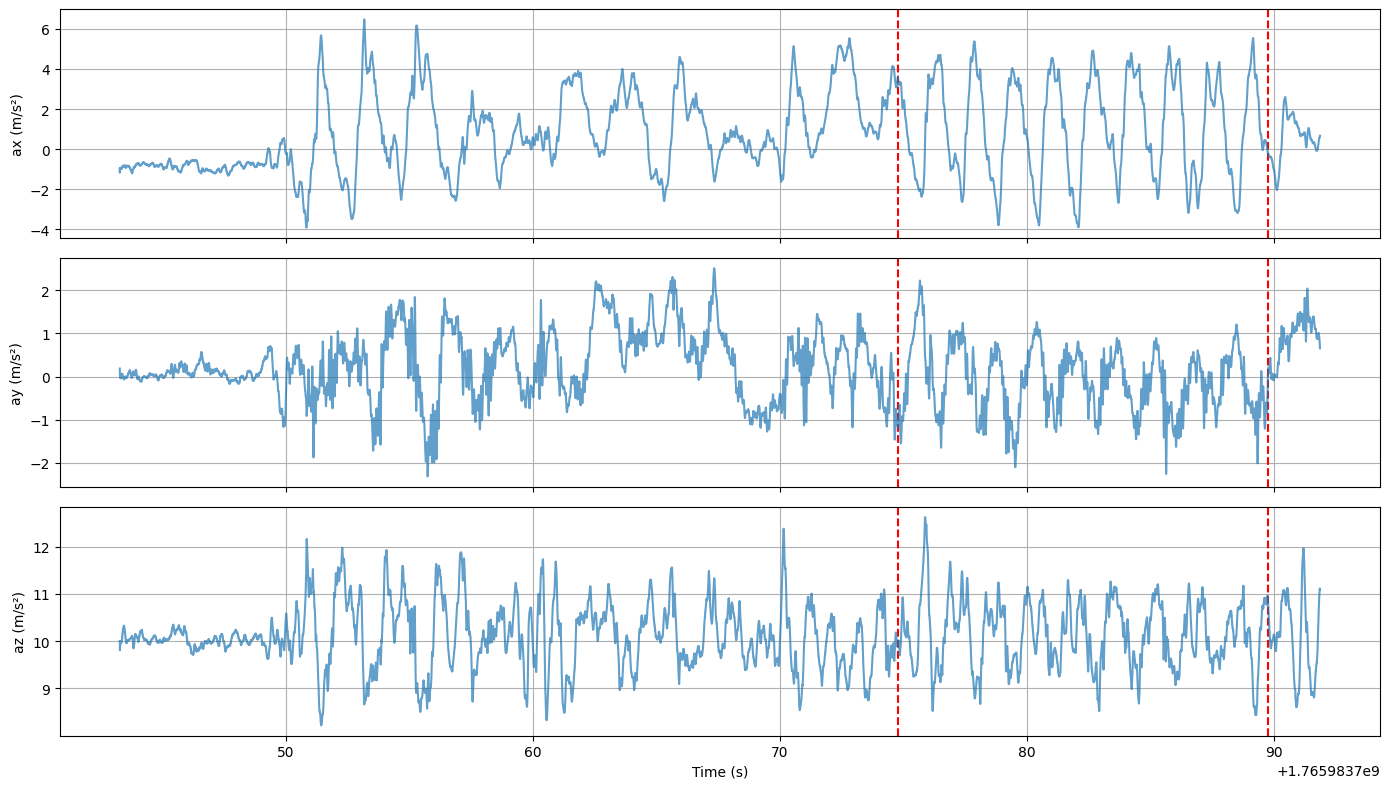

In [30]:
# Plot IMU acceleration
imu_df = pd.DataFrame([imu.to_dict() for imu in data.imu_data])

t_start = data.start_time + START_TIME_OFFSET
t_end = t_start + DURATION


fig, axes = plt.subplots(3, 1, sharex=True)

for ax in axes:
    ax.axvline(t_start, linestyle='--', c="red")
    ax.axvline(t_end, linestyle='--', c="red")

axes[0].plot(imu_df['timestamp'], imu_df['ax'], alpha=0.7)
axes[0].set_ylabel('ax (m/s²)')
axes[0].grid(True)

axes[1].plot(imu_df['timestamp'], imu_df['ay'], alpha=0.7)
axes[1].set_ylabel('ay (m/s²)')
axes[1].grid(True)

axes[2].plot(imu_df['timestamp'], imu_df['az'], alpha=0.7)
axes[2].set_ylabel('az (m/s²)')
axes[2].set_xlabel('Time (s)')
axes[2].grid(True)

plt.tight_layout()
plt.show()

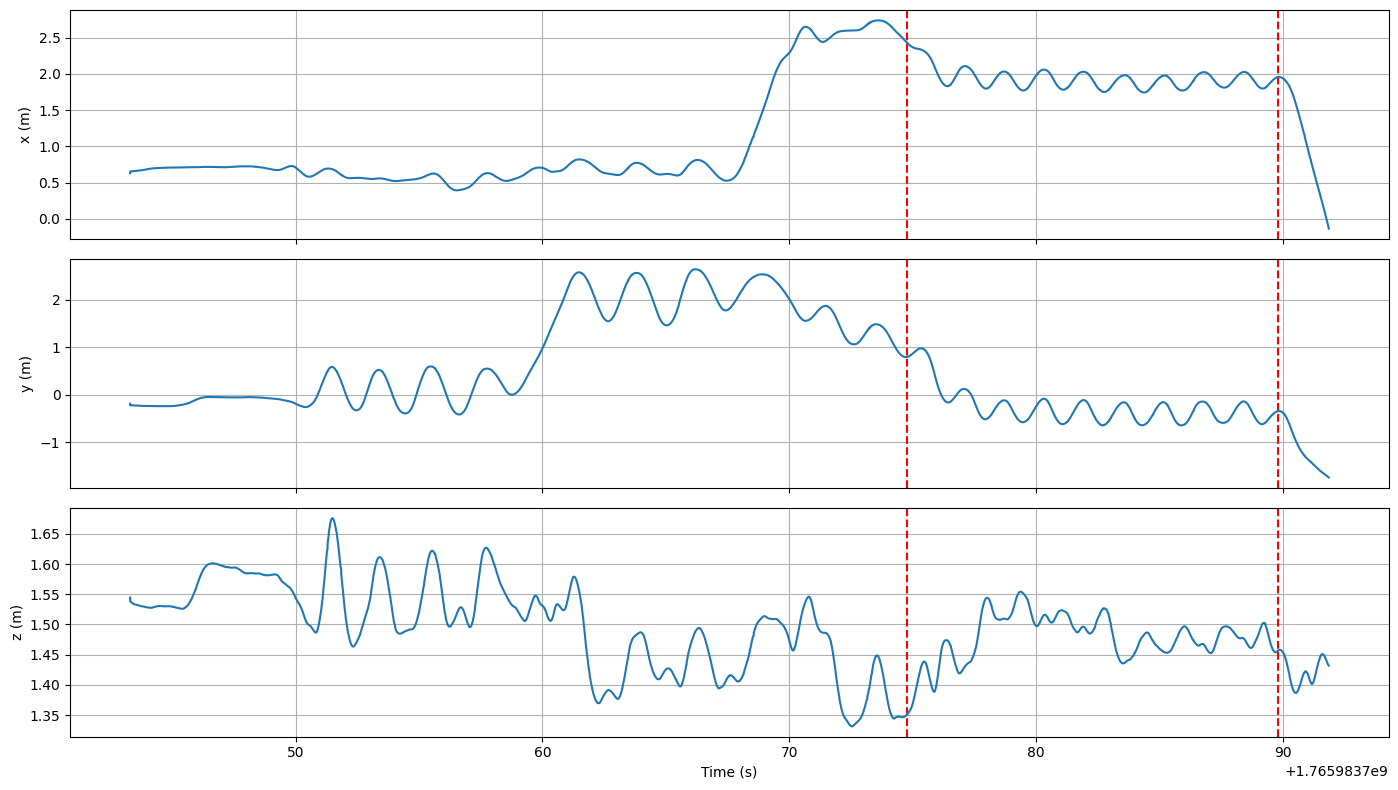

In [55]:
import numpy as np
from scipy.spatial.transform import Rotation as R


mocap_pose_df = pd.DataFrame([pose.to_dict() for pose in data.mocap_pose])

t = mocap_pose_df['timestamp'].to_numpy()
p = mocap_pose_df[['x', 'y', 'z']].to_numpy()

# world-frame velocity (central differences)
v_world = np.gradient(p, t, axis=0)

# quaternions (scipy expects [x, y, z, w])
q = mocap_pose_df[['qx', 'qy', 'qz', 'qw']].to_numpy()
rot = R.from_quat(q)

# rotate world velocity into body frame
v_body = rot.apply(v_world)

# body x velocity
v_body_x = v_body[:, 0]

fig, axs = plt.subplots(3, 1, sharex=True)
for ax in axs:
    ax.axvline(t_start, linestyle='--', c="red")
    ax.axvline(t_end, linestyle='--', c="red")
axs[0].plot(t, p[:, 0])
axs[0].set_ylabel("x (m)")
axs[0].grid(True)
axs[1].plot(t, p[:, 1])
axs[1].set_ylabel("y (m)")
axs[1].grid(True)
axs[2].plot(t, p[:, 2])
axs[2].set_ylabel("z (m)")
axs[2].set_xlabel("Time (s)")
axs[2].grid(True)
plt.tight_layout()
plt.show()



Index(['timestamp', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'qx', 'qy', 'qz', 'qw',
       'wx', 'wy', 'wz', 'ax', 'ay', 'az', 'motor1', 'motor2', 'motor3',
       'motor4'],
      dtype='object')


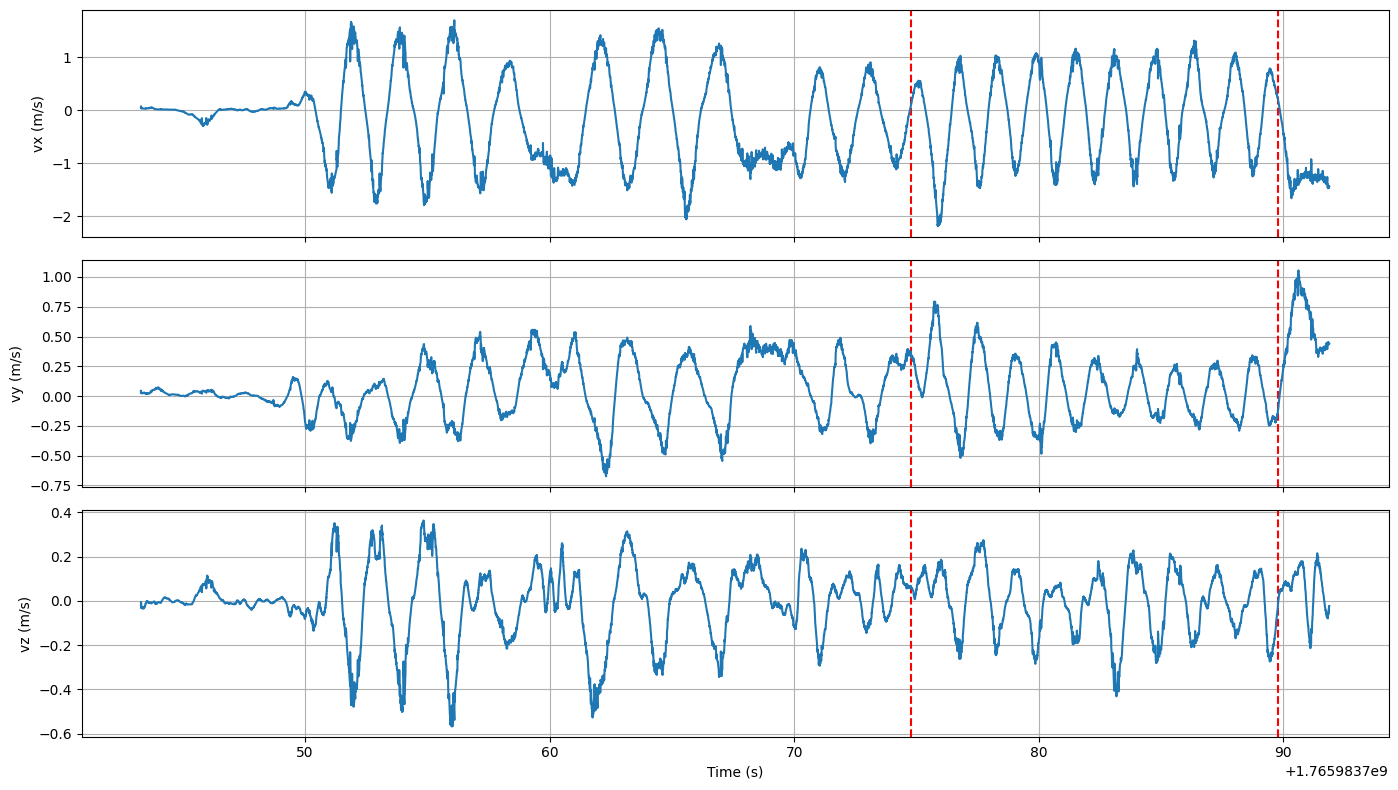

In [59]:
agiros_state_df = pd.DataFrame([state.to_dict() for state in data.agiros_state])
print(agiros_state_df.columns)

t = agiros_state_df['timestamp'].to_numpy()
v = agiros_state_df[['vx', 'vy', 'vz']].to_numpy()


v_world = agiros_state_df[['vx', 'vy', 'vz']].to_numpy()
q = agiros_state_df[['qx', 'qy', 'qz', 'qw']].to_numpy()

rot = R.from_quat(q)

# world -> body
v_body = rot.inv().apply(v_world)

v_body_x = v_body[:, 0]
v_body_y = v_body[:, 1]
v_body_z = v_body[:, 2]

fig, axs = plt.subplots(3, 1, sharex=True)
for ax in axs:
    ax.axvline(t_start, linestyle='--', c="red")
    ax.axvline(t_end, linestyle='--', c="red")
axs[0].plot(t, v_body_x)
axs[0].set_ylabel("vx (m/s)")
axs[0].grid(True)
axs[1].plot(t, v_body_y)
axs[1].set_ylabel("vy (m/s)")
axs[1].grid(True)
axs[2].plot(t, v_body_z)
axs[2].set_ylabel("vz (m/s)")
axs[2].set_xlabel("Time (s)")
axs[2].grid(True)
plt.tight_layout()
plt.show()



## Data Preparation

### Step 1: Crop Data from ROS Bag

In [ ]:
# Filter to time window of interest
t_start = data.start_time + START_TIME_OFFSET
t_end = t_start + DURATION

print(f"\n=== Time Window Selection ===")
print(f"Bag start:      {data.start_time:.2f} s")
print(f"Analysis start: {t_start:.2f} s (offset: {START_TIME_OFFSET:.1f} s)")
print(f"Analysis end:   {t_end:.2f} s")

# Filter all data to window
data.imu_data = [imu for imu in data.imu_data if t_start <= imu.timestamp <= t_end]
data.agiros_state = [state for state in data.agiros_state if t_start <= state.timestamp <= t_end]
data.radar_velocity = [radar for radar in data.radar_velocity if t_start <= radar.timestamp <= t_end]

print(f"\n=== Data Summary (Filtered) ===")
print(f"IMU samples:          {len(data.imu_data)}")
print(f"Agiros state samples: {len(data.agiros_state)}")
print(f"Radar frames:         {len(data.radar_velocity)}")
if len(data.imu_data) > 0:
    duration = data.imu_data[-1].timestamp - data.imu_data[0].timestamp
    print(f"Duration:             {duration:.2f} s")

Loading /workspace/rosbags/2025-12-17-16-02-22.bag...


Loading rosbag: 2025-12-17-16-02-22.bag
Duration: 48.59s
  Loading /mocap/angrybird2/pose...
  Loading /mocap/angrybird2/accel...
  Loading /angrybird2/agiros_pilot/state...
  Loading /angrybird2/agiros_pilot/odometry...
  Loading /angrybird2/imu...
  Loading /ti_mmwave/radar_scan_pcl_0...
  Loading /mmWaveDataHdl/RScanVelocity...
  Done!


=== Time Window Selection ===
Bag start:      1765983743.29 s
Analysis start: 1765983774.79 s (offset: 31.5 s)
Analysis end:   1765983789.79 s

=== Data Summary (Filtered) ===
IMU samples:          14917
Agiros state samples: 4503
Radar frames:         449
Duration:             15.00 s


### Step 2: Extract Agiros State (Validation Reference)


=== Agiros State ===
Samples:     4503
Sample rate: 300.2 Hz
Vx range:    [-0.88, 0.78] m/s


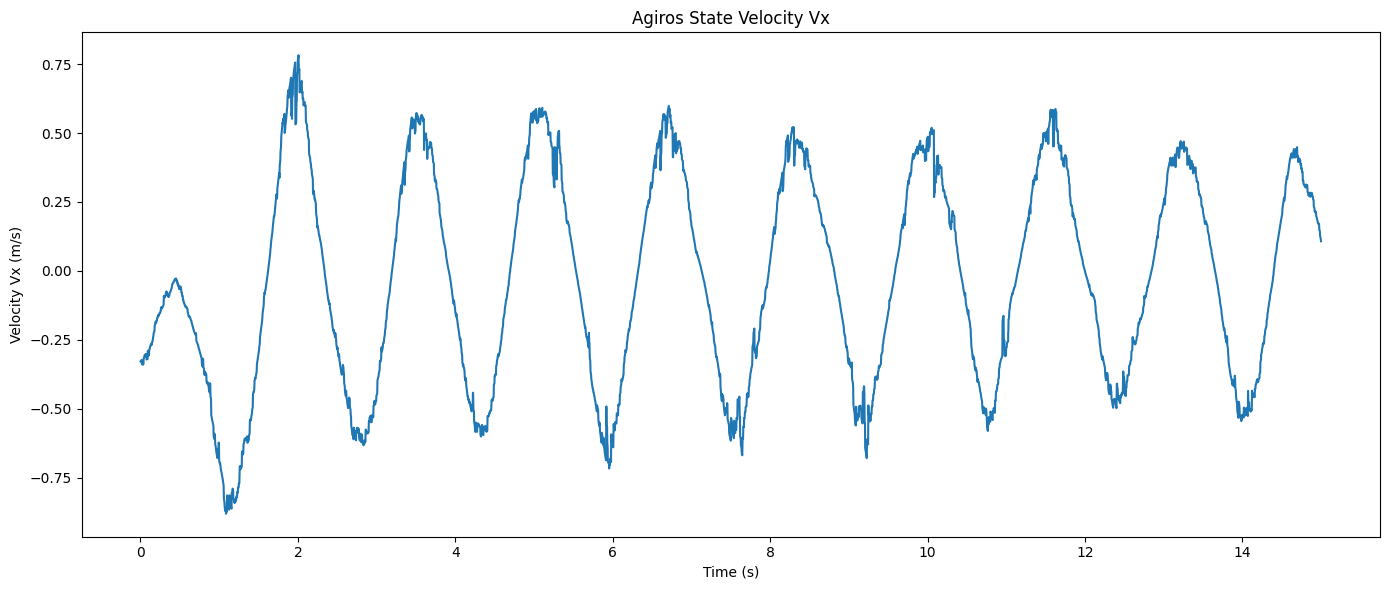

In [ ]:
# Extract state velocity
state_times = np.array([s.timestamp for s in data.agiros_state])
state_vx = np.array([s.velocity[0] for s in data.agiros_state])

print(f"\n=== Agiros State ===")
print(f"Samples:     {len(state_times)}")
print(f"Sample rate: {len(state_times) / (state_times[-1] - state_times[0]):.1f} Hz")
print(f"Vx range:    [{state_vx.min():.2f}, {state_vx.max():.2f}] m/s")

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(state_times - t_start, state_vx, label="Agiros State Vx")
ax.set_title("Agiros State Velocity Vx")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Velocity Vx (m/s)")
plt.tight_layout()
plt.show()

### Step 3: Integrate IMU Acceleration & Apply Drift Correction (Highpass Filter)

- Integrate X-axis acceleration to get velocity reference signal.
- Remove low-frequency drift from integrated velocity using highpass filter.

In [ ]:
imu_result = rv_utils.integrate_imu_acceleration(data.imu_data, axis='x')

print(f"=== IMU Integration ===\n")
print(f"Samples:          {len(imu_result['times'])}")
print(f"Estimated bias:   {imu_result['bias']:.4f} m/s²")
print(f"Sample rate:      {len(imu_result['times']) / (imu_result['times'][-1] - imu_result['times'][0]):.1f} Hz")
print(f"Raw velocity range: [{imu_result['velocity_raw'].min():.2f}, {imu_result['velocity_raw'].max():.2f}] m/s")

# Compute sample rate
sample_rate_imu = len(imu_result['times']) / (imu_result['times'][-1] - imu_result['times'][0])


# Apply highpass filter
imu_result['velocity_filtered'] = rv_utils.apply_highpass_filter(
    imu_result['velocity_raw'],
    cutoff_hz=IMU_HIGHPASS_CUTOFF,
    sample_rate_hz=sample_rate_imu,
    order=2
)

print(f"\n=== Drift Correction ===\n")
print(f"Highpass cutoff:      {IMU_HIGHPASS_CUTOFF} Hz")
print(f"Filtered velocity range: [{imu_result['velocity_filtered'].min():.2f}, {imu_result['velocity_filtered'].max():.2f}] m/s")


=== IMU Integration ===

Samples:          14917
Estimated bias:   0.0000 m/s²
Sample rate:      994.6 Hz
Raw velocity range: [-1.84, 1.57] m/s

=== Drift Correction ===

Highpass cutoff:      0.2 Hz
Filtered velocity range: [-1.12, 1.09] m/s


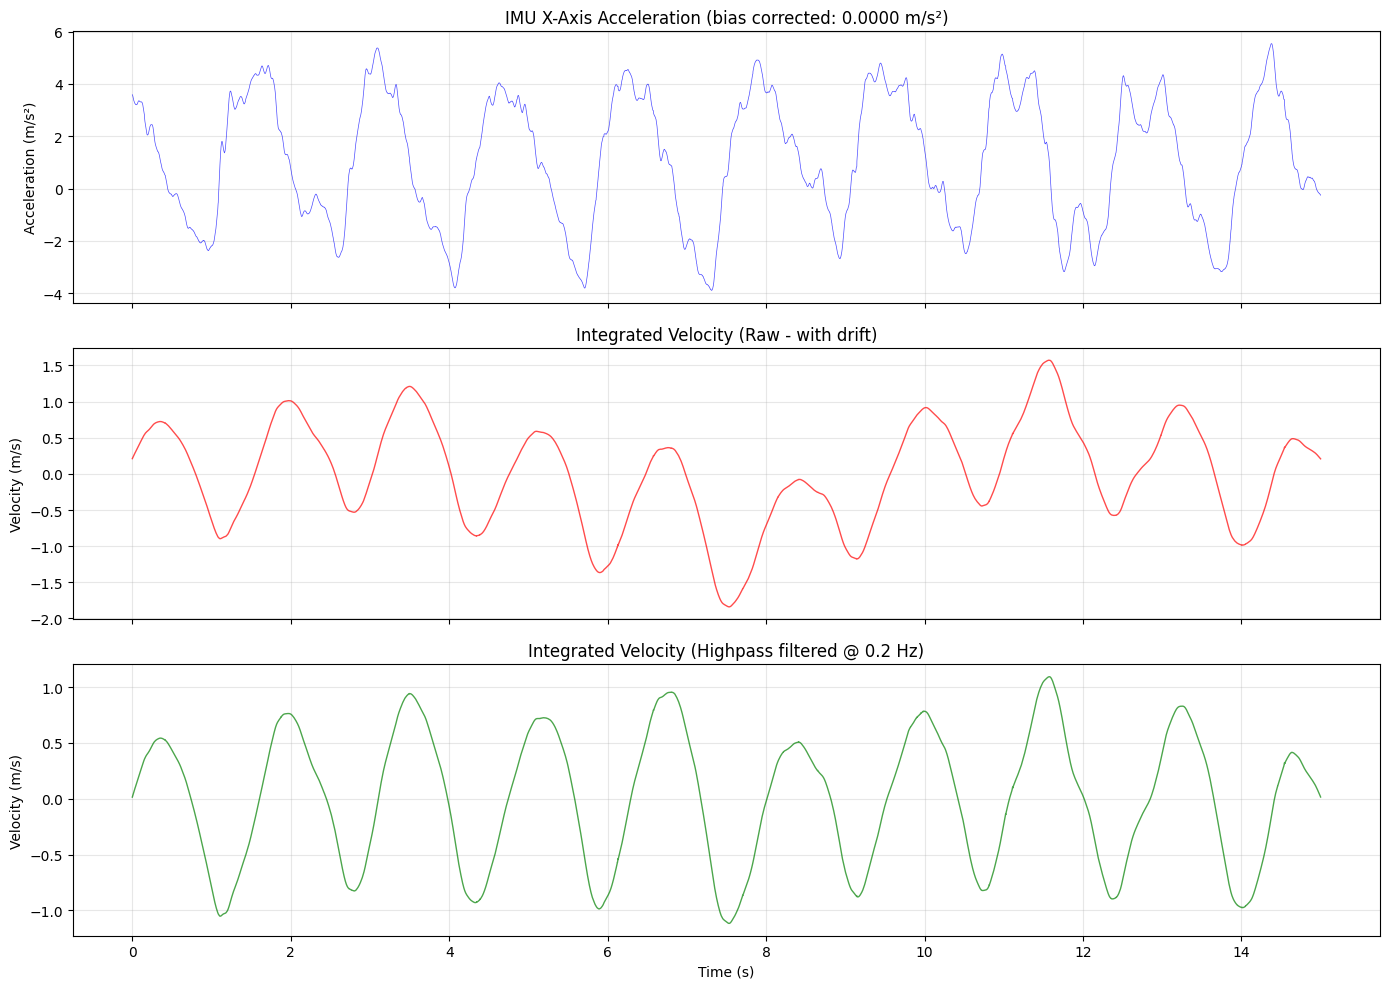

In [ ]:

# Visualization: Before vs After drift correction
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

t0 = imu_result['times'][0]
t_rel = imu_result['times'] - t0

# Plot 1: Acceleration
axes[0].plot(t_rel, imu_result['acceleration'], 'b-', linewidth=0.5, alpha=0.7)
axes[0].set_ylabel('Acceleration (m/s²)')
axes[0].set_title(f'IMU X-Axis Acceleration (bias corrected: {imu_result["bias"]:.4f} m/s²)')
axes[0].grid(True, alpha=0.3)

# Plot 2: Raw integrated velocity (with drift)
axes[1].plot(t_rel, imu_result['velocity_raw'], 'r-', linewidth=1, alpha=0.7)
axes[1].set_ylabel('Velocity (m/s)')
axes[1].set_title('Integrated Velocity (Raw - with drift)')
axes[1].grid(True, alpha=0.3)

# Plot 3: Filtered velocity (drift removed)
axes[2].plot(t_rel, imu_result['velocity_filtered'], 'g-', linewidth=1, alpha=0.7)
axes[2].set_xlabel('Time (s)')
axes[2].set_ylabel('Velocity (m/s)')
axes[2].set_title(f'Integrated Velocity (Highpass filtered @ {IMU_HIGHPASS_CUTOFF} Hz)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Step 4: Fix CPU Counter Resets

The radar's 32-bit CPU counter can overflow (~21.5 seconds at 200 MHz). 
We detect and correct these resets to maintain a continuous timeline.
Then we fit them again ros time to see if they correlate well.

=== CPU Counter Reset Correction ===

⚠️  CPU counter reset detected!
  Split boundary: 1.507B cycles
  Segment 1: 34 frames, R²=0.999997, 200.03 MHz
  Segment 2: 415 frames, R²=1.000000, 200.03 MHz
  Stitching: offset=4.301B, gap=33.1ms
  Result: R²=0.999998, clock=200.18 MHz
  ✓ CPU counter reset corrected successfully

✅ CPU counter resets corrected!
   Stitched R² = 0.999998
   Clock freq  = 200.18 MHz


=== CPU Cycle Calibration (Initial Fit to ROS) ===

Linear model: t_ros = 4.9954724670e-09 × cpu_cycles + 1765983767.1789
R² = 0.999998 (should be close to 1.0)
Clock frequency = 200.18 MHz


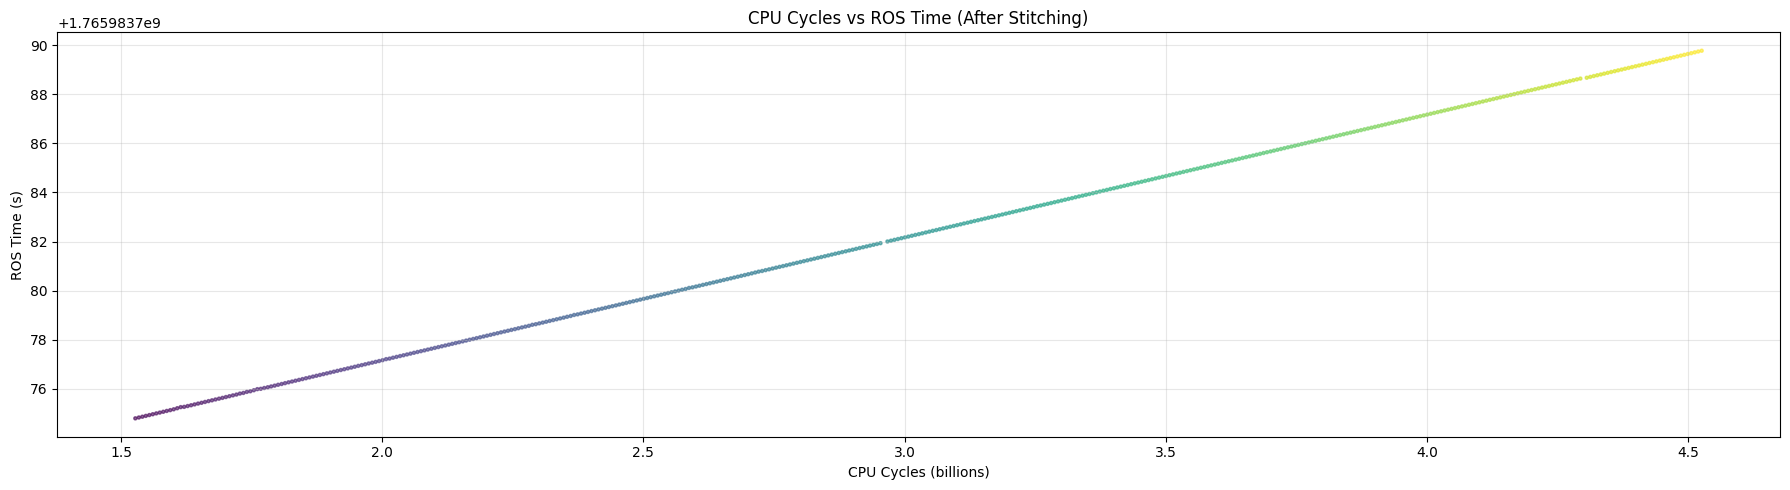

In [ ]:
print("=== CPU Counter Reset Correction ===")

# Apply automatic stitching
radar_frames_raw = data.radar_velocity.copy()
data.radar_velocity, stitch_diagnostics = rosbag_loader.stitch_cpu_counter_resets(
    radar_frames_raw, verbose=True
)

if stitch_diagnostics.get("resets_detected", False):
    print(f"✅ CPU counter resets corrected!")
    print(f"   Stitched R² = {stitch_diagnostics.get('r_squared_after', 0):.6f}")
    print(f"   Clock freq  = {stitch_diagnostics.get('clock_freq_mhz', 0):.2f} MHz")
else:
    print(f"✓ No resets detected - data is continuous")



# Linear fit: CPU cycles vs ROS time
times_ros  = np.array([frame.timestamp for frame in data.radar_velocity])
cycles_cpu = np.array([frame.time_cpu_cycles[0] for frame in data.radar_velocity])
slope_init, intercept_init, r_init, _, _ = linregress(
    cycles_cpu, 
    times_ros
)
clock_freq_mhz = 1.0 / slope_init / 1e6

print(f"\n\n=== CPU Cycle Calibration (Initial Fit to ROS) ===")
print(f"\nLinear model: t_ros = {slope_init:.10e} × cpu_cycles + {intercept_init:.4f}")
print(f"R² = {r_init**2:.6f} (should be close to 1.0)")
print(f"Clock frequency = {clock_freq_mhz:.2f} MHz")

# Visualization
fig, ax = plt.subplots(figsize=(18, 5))
# ax.plot(cycles_cpu/1e9, slope_init * cycles_cpu + intercept_init, 'r-', linewidth=2, alpha=0.7, label=f'Linear fit (R²={r_init**2:.6f})')
ax.scatter(cycles_cpu/1e9, times_ros, s=5, alpha=0.6, c=np.arange(len(cycles_cpu)), cmap='viridis')
ax.set_xlabel('CPU Cycles (billions)')
ax.set_ylabel('ROS Time (s)')
ax.set_title('CPU Cycles vs ROS Time (After Stitching)')
# ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### <font color='red'>Investigate Gaps!</font>

### Step 5: Estimate Radar Ego-Velocity

Use Weighted Least Squares to solve for body velocity from Doppler measurements:

$$\mathbf{v}_{body} = \arg\min_{\vec{v}} \sum_{i=1}^{N} w_i (\hat{r}_i \cdot \vec{v} - v_{rad,i})^2$$

where $w_i = \text{intensity}_i$ (trust brighter returns more).

In [ ]:
radar_data = rv_utils.process_radar_frames(
    data.radar_velocity,
    min_intensity=MIN_INTENSITY,
    min_range=MIN_RANGE,
    min_points=MIN_POINTS
)

# Filter out invalid CPU cycles
print(len(data.radar_velocity))
print(len(radar_data['cpu_cycles']))
radar_data = rv_utils.filter_valid_cpu_cycles(radar_data)
print(len(radar_data['cpu_cycles']))

print(f"=== Radar Velocity Estimates ===\n")
print(f"Valid frames:     {len(radar_data['times_ros'])}")
print(f"ROS time range:   [{radar_data['times_ros'][0]:.2f}, {radar_data['times_ros'][-1]:.2f}] s")
print(f"CPU cycle range:  [{radar_data['cpu_cycles'][0]/1e9:.3f}, {radar_data['cpu_cycles'][-1]/1e9:.3f}] B")
print(f"Vx range:         [{radar_data['vx'].min():.2f}, {radar_data['vx'].max():.2f}] m/s")
print(f"Duration:         {radar_data['times_ros'][-1] - radar_data['times_ros'][0]:.2f} s")

# Verify monotonicity
cpu_monotonic = np.all(np.diff(radar_data['cpu_cycles']) > 0)
ros_monotonic = np.all(np.diff(radar_data['times_ros']) > 0)
print(f"\nMonotonicity:")
print(f"  ROS timestamps: {'✓' if ros_monotonic else '✗'}")
print(f"  CPU cycles:     {'✓' if cpu_monotonic else '✗'}")

449
292
292
=== Radar Velocity Estimates ===

Valid frames:     292
ROS time range:   [1765983774.84, 1765983789.77] s
CPU cycle range:  [1.534, 4.526] B
Vx range:         [-1.64, 1.92] m/s
Duration:         14.93 s

Monotonicity:
  ROS timestamps: ✓
  CPU cycles:     ✓


### Step 6: Filter Radar Velocity

Apply lowpass filter to reduce Doppler noise.

In [ ]:
# Compute radar sample rate
time_span = radar_data['times_ros'][-1] - radar_data['times_ros'][0]
sample_rate_radar = len(radar_data['times_ros']) / time_span

print(f"=== Radar Filtering ===\n")
print(f"Sample rate: {sample_rate_radar:.1f} Hz")
print(f"Lowpass cutoff: {RADAR_LOWPASS_CUTOFF} Hz")

if sample_rate_radar > 2 * RADAR_LOWPASS_CUTOFF:
    radar_data['vx_filtered'] = rv_utils.apply_lowpass_filter(
        radar_data['vx'],
        cutoff_hz=RADAR_LOWPASS_CUTOFF,
        sample_rate_hz=sample_rate_radar,
        order=2
    )
    print(f"✓ Filter applied")
    print(f"   Before: [{radar_data['vx'].min():.2f}, {radar_data['vx'].max():.2f}] m/s")
    print(f"   After:  [{radar_data['vx_filtered'].min():.2f}, {radar_data['vx_filtered'].max():.2f}] m/s")
else:
    print(f"✗  Sample rate too low - using unfiltered data")
    radar_data['vx_filtered'] = radar_data['vx'].copy()

=== Radar Filtering ===

Sample rate: 19.6 Hz
Lowpass cutoff: 3.0 Hz
✓ Filter applied
   Before: [-1.64, 1.92] m/s
   After:  [-1.63, 1.28] m/s


### Step 7: Summary - Prepared Data Structure

All data is now ready for timestamp calibration and optimization.

In [ ]:
print("\n" + "="*60)
print("DATA PREPARATION COMPLETE")
print("="*60)

print(f"\nRadar Data:")
print(f"  Frames:           {len(radar_data['times_ros'])}")
print(f"  ROS timestamps:   [{radar_data['times_ros'][0]:.2f}, {radar_data['times_ros'][-1]:.2f}] s")
print(f"  CPU cycles:       [{radar_data['cpu_cycles'][0]/1e9:.3f}, {radar_data['cpu_cycles'][-1]/1e9:.3f}] B")
print(f"  Vx (filtered):    [{radar_data['vx_filtered'].min():.2f}, {radar_data['vx_filtered'].max():.2f}] m/s")

print(f"\nIMU Data:")
print(f"  Samples:          {len(imu_result['times'])}")
print(f"  Timestamps:       [{imu_result['times'][0]:.2f}, {imu_result['times'][-1]:.2f}] s")
print(f"  Vx (filtered):    [{imu_result['velocity_filtered'].min():.2f}, {imu_result['velocity_filtered'].max():.2f}] m/s")
print(f"  Sample rate:      {sample_rate_imu:.1f} Hz")

print(f"\nAgiros State:")
print(f"  Samples:          {len(state_times)}")
print(f"  Vx range:         [{state_vx.min():.2f}, {state_vx.max():.2f}] m/s")

print(f"\nInitial CPU Calibration:")
print(f"  Slope:            {slope_init:.10e} s/cycle")
print(f"  Intercept:        {intercept_init:.4f} s")
print(f"  Clock frequency:  {clock_freq_mhz:.2f} MHz")
print(f"  Fit quality (R²): {r_init**2:.6f}")


DATA PREPARATION COMPLETE

Radar Data:
  Frames:           292
  ROS timestamps:   [1765983774.84, 1765983789.77] s
  CPU cycles:       [1.534, 4.526] B
  Vx (filtered):    [-1.63, 1.28] m/s

IMU Data:
  Samples:          14917
  Timestamps:       [1765983774.79, 1765983789.79] s
  Vx (filtered):    [-1.12, 1.09] m/s
  Sample rate:      994.6 Hz

Agiros State:
  Samples:          4503
  Vx range:         [-0.88, 0.78] m/s

Initial CPU Calibration:
  Slope:            4.9954724670e-09 s/cycle
  Intercept:        1765983767.1789 s
  Clock frequency:  200.18 MHz
  Fit quality (R²): 0.999998


## Analysis

### Step 1: Ros Time vs Clock Cycles

Get the std of the ros timestamps.


=== CPU Cycle Calibration (Initial Fit to ROS) ===
Linear model: t_ros = 4.9948909941e-09 × cpu_cycles + 1765983767.1804
R² = 0.999997 (should be > 0.999)
Clock frequency = 200.20 MHz

=== USB Timing Jitter ===
Std dev (σ): 7.153 ms
Max:         20.452 ms
95th %ile:   18.573 ms


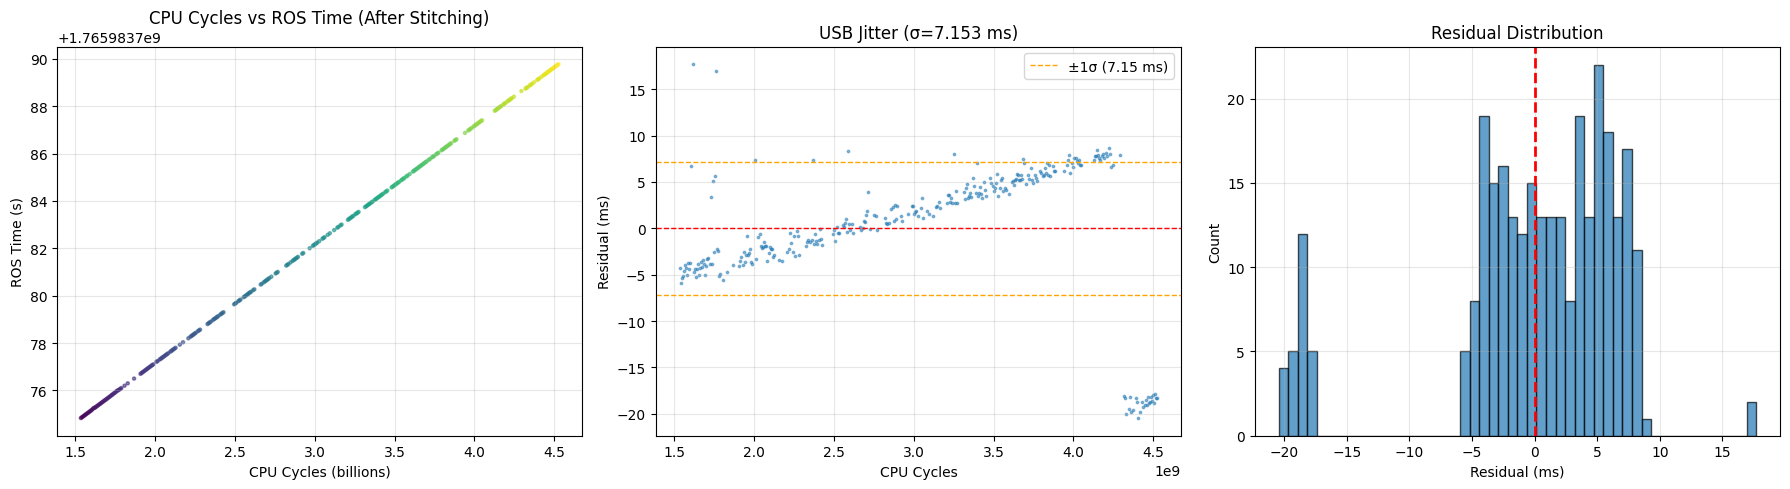

In [ ]:
# Linear fit: CPU cycles vs ROS time
slope_init, intercept_init, r_init, _, _ = linregress(
    radar_data['cpu_cycles'], 
    radar_data['times_ros']
)
clock_freq_mhz = 1.0 / slope_init / 1e6

print(f"\n=== CPU Cycle Calibration (Initial Fit to ROS) ===")
print(f"Linear model: t_ros = {slope_init:.10e} × cpu_cycles + {intercept_init:.4f}")
print(f"R² = {r_init**2:.6f} (should be > 0.999)")
print(f"Clock frequency = {clock_freq_mhz:.2f} MHz")

# Compute residuals (USB jitter)
residuals = radar_data['times_ros'] - (slope_init * radar_data['cpu_cycles'] + intercept_init)
usb_jitter_std = np.std(residuals) * 1000  # ms

print(f"\n=== USB Timing Jitter ===")
print(f"Std dev (σ): {usb_jitter_std:.3f} ms")
print(f"Max:         {np.max(np.abs(residuals)) * 1000:.3f} ms")
print(f"95th %ile:   {np.percentile(np.abs(residuals), 95) * 1000:.3f} ms")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: CPU cycles vs ROS time
axes[0].scatter(radar_data['cpu_cycles']/1e9, radar_data['times_ros'], 
                s=5, alpha=0.6, c=np.arange(len(radar_data['cpu_cycles'])), cmap='viridis')
# axes[0].plot(radar_data['cpu_cycles']/1e9, slope_init * radar_data['cpu_cycles'] + intercept_init, 'r-', linewidth=2, alpha=0.7, label=f'Linear fit (R²={r_init**2:.6f})')
axes[0].set_xlabel('CPU Cycles (billions)')
axes[0].set_ylabel('ROS Time (s)')
axes[0].set_title('CPU Cycles vs ROS Time (After Stitching)')
# axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Residuals (USB jitter)
axes[1].scatter(radar_data['cpu_cycles'], residuals * 1000, s=3, alpha=0.5)
axes[1].axhline(0, color='r', linestyle='--', linewidth=1)
axes[1].axhline(usb_jitter_std, color='orange', linestyle='--', linewidth=1, 
                label=f'±1σ ({usb_jitter_std:.2f} ms)')
axes[1].axhline(-usb_jitter_std, color='orange', linestyle='--', linewidth=1)
axes[1].set_xlabel('CPU Cycles')
axes[1].set_ylabel('Residual (ms)')
axes[1].set_title(f'USB Jitter (σ={usb_jitter_std:.3f} ms)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Residual histogram
axes[2].hist(residuals * 1000, bins=50, alpha=0.7, edgecolor='black')
axes[2].axvline(0, color='r', linestyle='--', linewidth=2)
axes[2].set_xlabel('Residual (ms)')
axes[2].set_ylabel('Count')
axes[2].set_title('Residual Distribution')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()